In [13]:
import sys

import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
import pandas as pd
import healpy as hp
from tqdm import *
import emcee
import corner

import distances
from gaussianprocess import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gaussian process regression on a sphere

In [2]:
nside = 16

In [3]:
# Helper functions

def idx_to_dec_ra(nside, index):
    """ Return DEC, RA corresponding to HEALPIX pixel ``index`` of given ``nside``
    """
    theta, phi = hp.pixelfunc.pix2ang(nside, index)
    return -np.degrees(theta - np.pi/2.), np.degrees(2*np.pi - phi)

def dec_ra_to_idx(nside, dec,ra):
    """ Return index corresponding to HEALPIX resolution ``nside`` for given 
        angular coordinates ``dec``, ``ra``
    """
    return hp.pixelfunc.ang2pix(nside,np.radians(-dec + 90.), np.radians(360. - ra))

In [4]:
# Load proper motion and pm noise maps made in the other notebook
pm_v_map = np.load("data/pm_v_map_nside" + str(nside) + ".npy")
pm_v_noise_map = np.load("data/pm_v_noise_map_nside" + str(nside) + ".npy")

In [5]:
# Downgraded RA and DEC values on the healpix sphere
dec_down, ra_down = idx_to_dec_ra(nside, np.arange(len(pm_v_map)))

In [6]:
# Get distance matrix for kernel covariance
d = distances.calc_all_dist(ra_down, dec_down, ra_down, dec_down, chord=False)
d[np.arange(d.shape[0]), np.arange(d.shape[1])] = 0
logd = np.log(d)

/home/sm8383/GaiaSprint/distances.py:30: RuntimeWarning: invalid value encountered in arccos
  np.cos(dec)*np.cos(dec_ref)*np.cos(ra_ref - ra))
/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [7]:
# Check LL
explorelike([1,1,.1], d, d, logd, logd, pm_v_map, pm_v_noise_map)

784.8519300138394

## Gaussian process regression

In [17]:
# Initial guess
p = np.array([30, 1.2, 5.e-2])

# LL arguments
args = (d, d, logd, logd, pm_v_map, pm_v_noise_map)

In [9]:
# Fit for kernel hyperparameters

p1 = optimize.minimize(explorelike, p, args, method='L-BFGS-B', 
                        bounds=[[10.,100000.],[0.1,1.5],[0.001,0.4]],
                        options={'disp': None, 'maxcor': 10, 'ftol': 2.220446049250313e-9, 'gtol': 1e-07, 'eps': 1e-09, 'maxfun': 15000, 'maxiter': 15000, 'iprint': -1, 'maxls': 20}
)

In [10]:
# Look at fit
x = p1.x # Best-fit parameters
p1

      fun: 0.03298001404791746
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00056043,  0.00017295, -0.00199796])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 84
      nit: 8
   status: 0
  success: True
        x: array([3.00000083e+02, 1.49977556e+00, 5.11126673e-02])

In [18]:
# Initial guess vs best-fit likelihood
print("Initial guess LL = ", explorelike(p, *args))
print("Best-fit LL = ", explorelike(x, *args))

Initial guess LL =  2.5732575501028574
Best-fit LL =  0.03298001404791746


In [15]:
# Get GP model map
opt = gaussianprocess(d, d, logd, logd, pm_v_map, pm_v_noise_map, *p)

/scratch/sm8383/anaconda3/envs/venv_smsharma/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


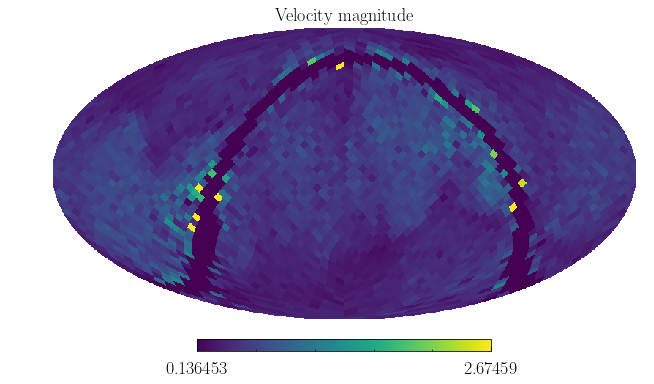

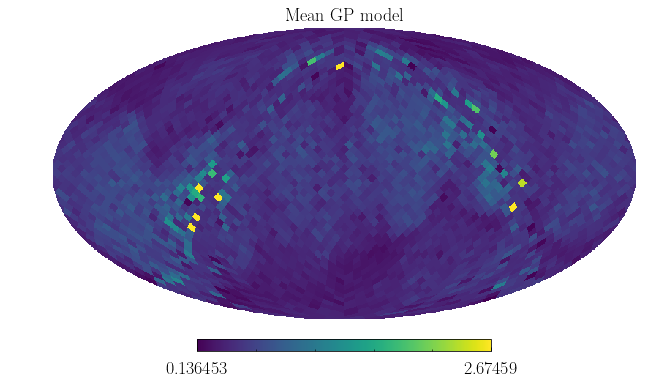

In [16]:
# Compare GP model with original map
hp.mollview(pm_v_map, title="Velocity magnitude", min=np.min(opt), max=np.max(opt)/2.)
hp.mollview(opt, title="Mean GP model", min=np.min(opt), max=np.max(opt)/2.)

## MCMC

In [ ]:
ndim, nwalkers = 3, 100
x_new = x
x_new[0] = np.log10(x_new[0])
pos = [x_new + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [ ]:
def lnprob(x, d, d_cross, logd, logd_cross, pm_v_map, pm_v_noise_map):
    if not (1. < x[0] < 4. or 0. < x[1] < 10. or 0. < x[2] < 0.5):
        return -np.inf
    else:
        return -explorelike([10**x[0],x[1],x[2]], d, d_cross, logd, logd_cross, pm_v_map, pm_v_noise_map)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args,threads=6)

In [ ]:
nsteps = 100
width = 30
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    n = int((width+1) * float(i) / nsteps)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))
sys.stdout.write("\n")

In [ ]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [ ]:
corner.corner(samples, labels=["$\sigma^2$", "$\alpha$", "$\nu$"], range=[[3000.,3500.],[0.0,1.5],[0.001,0.4]]);